
Computing Error-Bars to estimate the effect of randomly initialised parameters 
==

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import folie as fl
from copy import deepcopy

 This notebook runs a simulation once to generate data, then for each estimator run 3 different estimations starting from different coefficients $ \sim \mathcal{N}(\mu,\sigma^2)$  
Run the estimation starting from random parameters $M$ times

Choose the Hyper-parameters : $\mu$, $\sigma$, $M$ 

In [2]:
mu = 3
sigma = 1
M = 3 # number of differnt estimation for a given estimator and given data
np.random.seed(3)

## Generate data

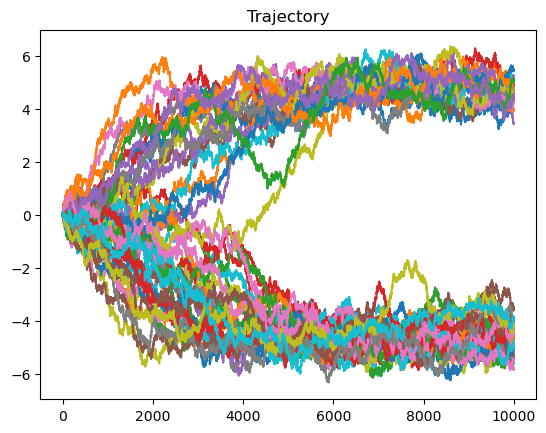

In [3]:
coeff = 0.2 * np.array([0, 0, -4.5, 0, 0.1])
free_energy = np.polynomial.Polynomial(coeff)
D = 0.5
force_coeff = D * np.array([-coeff[1], -2 * coeff[2], -3 * coeff[3], -4 * coeff[4]])

force_function = fl.functions.Polynomial(deg=3, coefficients=force_coeff)
diff_function = fl.functions.Polynomial(deg=0, coefficients=np.array(D))

# Plot of Free Energy and Force
x_values = np.linspace(-7, 7, 100)

# Define model to simulate and type of simulator to use
dt = 1e-3
model_simu = fl.models.overdamped.Overdamped(force_function, diffusion=diff_function)
simulator = fl.simulations.Simulator(fl.simulations.EulerStepper(model_simu), dt)


# initialize positions
ntraj = 50
q0 = np.empty(ntraj)
for i in range(len(q0)):
    q0[i] = 0
# Calculate Trajectory
time_steps = 10000
data = simulator.run(time_steps, q0, save_every=1)

# Plot resulting Trajectories
fig, axs = plt.subplots()
for n, trj in enumerate(data):
    axs.plot(trj["x"])
    axs.set_title("Trajectory")


## Training


### Euler Training 

random [2.7226118  2.64524102 2.91725852 2.37299932 2.95618183 2.52278197
 1.68613525 3.88462238]


/home/dbersano/folie/folie/estimation/transitionDensity.py:20: RuntimeWarning: invalid value encountered in log
  ll = -0.5 * ((xt.ravel() - E) ** 2 / V) - 0.5 * np.log(np.sqrt(2 * np.pi) * V)
/home/dbersano/folie/folie/estimation/transitionDensity.py:20: RuntimeWarning: invalid value encountered in log
  ll = -0.5 * ((xt.ravel() - E) ** 2 / V) - 0.5 * np.log(np.sqrt(2 * np.pi) * V)
/home/dbersano/folie/folie/estimation/transitionDensity.py:20: RuntimeWarning: invalid value encountered in log
  ll = -0.5 * ((xt.ravel() - E) ** 2 / V) - 0.5 * np.log(np.sqrt(2 * np.pi) * V)
/home/dbersano/folie/folie/estimation/transitionDensity.py:20: RuntimeWarning: invalid value encountered in log
  ll = -0.5 * ((xt.ravel() - E) ** 2 / V) - 0.5 * np.log(np.sqrt(2 * np.pi) * V)


Euler 1 [  4.26604296 -11.42518271  11.1839546   -3.97643622   0.50641358
   0.48436748   0.50919854   0.49611813]
random [3.88131804 4.70957306 3.05003364 2.59532259 2.45464005 1.45352268
 3.98236743 1.89893237]
Euler 2 [  4.26607639 -11.42829019  11.17660047  -3.97111746   0.50624366
   0.4847656    0.50902849   0.49613225]
random [1.81495347 2.7943501  4.48614836 3.23671627 1.97621486 2.2870068
 3.62524497 2.83948664]
Euler 3 [  4.26684597 -11.4215051   11.1662353   -3.96503471   0.50636376
   0.48460779   0.5089103    0.49624507]
Euler KM [  4.26453311 -11.42115499  11.17325308  -3.97170219   0.50618638
   0.48489797   0.50877457   0.49627617]


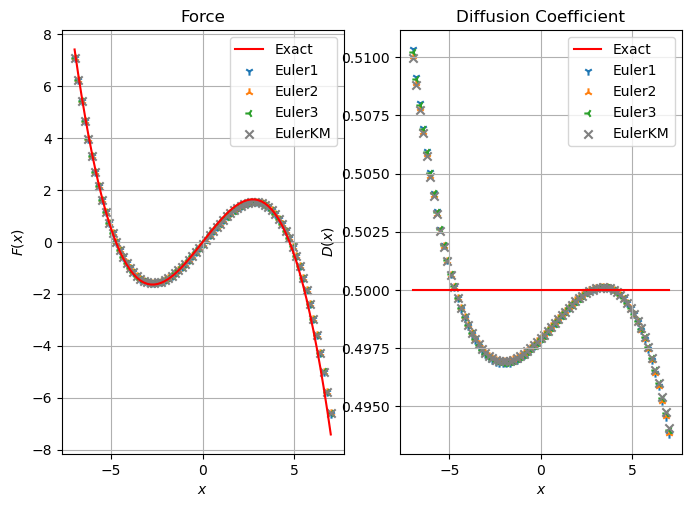

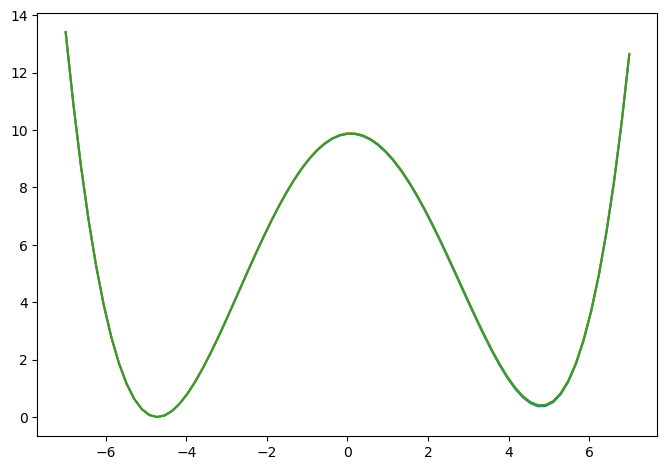

In [4]:
fig, axs = plt.subplots(1, 2,figsize=(8,5.5))
fig, axf = plt.subplots(figsize=(8,5.5))
np.random.seed(3)
axs[0].set_title("Force")
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$F(x)$")
axs[0].grid()
axs[1].set_title("Diffusion Coefficient")
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$D(x)$")
axs[1].grid()

xfa = np.linspace(-7.0, 7.0, 75)
axs[0].plot(xfa, model_simu.force(xfa.reshape(-1, 1)),color='r', label="Exact")
axs[1].plot(xfa, model_simu.diffusion(xfa.reshape(-1, 1)), color='r',label="Exact")

nknots=4
domain = fl.MeshedDomain.create_from_range(np.linspace(data.stats.min, data.stats.max, nknots).ravel())
trainmodel = fl.models.Overdamped(force=fl.functions.BSplinesFunction(domain), has_bias=None)

Euler_res=[]
Euler_fes=[]
markers=['1','2','3']
for index in range(M):
    coefficients0= np.random.normal(loc=mu, scale=sigma, size=2*nknots)
    print('random',coefficients0)
    estimator = fl.LikelihoodEstimator(fl.EulerDensity(trainmodel) ,n_jobs=4)
    Euler_res.append(estimator.fit_fetch(data,coefficients0=coefficients0))
    print('Euler',index +1,Euler_res[index].coefficients)
    axs[0].scatter(xfa, Euler_res[index].force(xfa.reshape(-1, 1)), marker=markers[index], label='Euler'+str(index+1))
    axs[1].scatter(xfa, Euler_res[index].diffusion(xfa.reshape(-1, 1)), marker=markers[index], label='Euler'+str(index+1))
    Euler_fes.append(fl.analysis.free_energy_profile_1d(Euler_res[index],xfa))
    axf.plot(xfa,Euler_fes[index])

Euler_res0=fl.LikelihoodEstimator(fl.EulerDensity(trainmodel) ,n_jobs=4).fit_fetch(data)
print('Euler KM',Euler_res0.coefficients)
axs[0].scatter(xfa, Euler_res0.force(xfa.reshape(-1, 1)),color = 'grey', marker='x', label='EulerKM')
axs[1].scatter(xfa, Euler_res0.diffusion(xfa.reshape(-1, 1)), color = 'grey',marker='x', label='EulerKM')

axs[0].legend()
axs[1].legend()


#### Euler errorbars

[0.02487358 0.02290882 0.0222288  0.02189822 0.02135646 0.02034349
 0.01877521 0.01665805 0.01404174 0.01099459 0.00759065 0.00390297
 0.         0.00405637 0.00821182 0.01242014 0.01664353 0.02085268
 0.02502677 0.0291534  0.03322832 0.03725513 0.04124474 0.04521467
 0.04918814 0.05319287 0.05725978 0.06142141 0.0657103  0.07015737
 0.07479034 0.07963239 0.08470106 0.09000749 0.09555596 0.10134373
 0.10736123 0.11359233 0.12001491 0.12660136 0.13331924 0.1401319
 0.14699905 0.15387729 0.16072065 0.16748092 0.17410807 0.18055047
 0.18675516 0.19266797 0.1982336  0.20339571 0.20809689 0.21227864
 0.21588129 0.218844   0.22110466 0.22259999 0.22326569 0.2230368
 0.2218485  0.21963738 0.21634373 0.21191518 0.20631279 0.19952095
 0.19156369 0.18253155 0.17262643 0.16223523 0.15204649 0.14321357
 0.13751176 0.13729365 0.1449575 ]


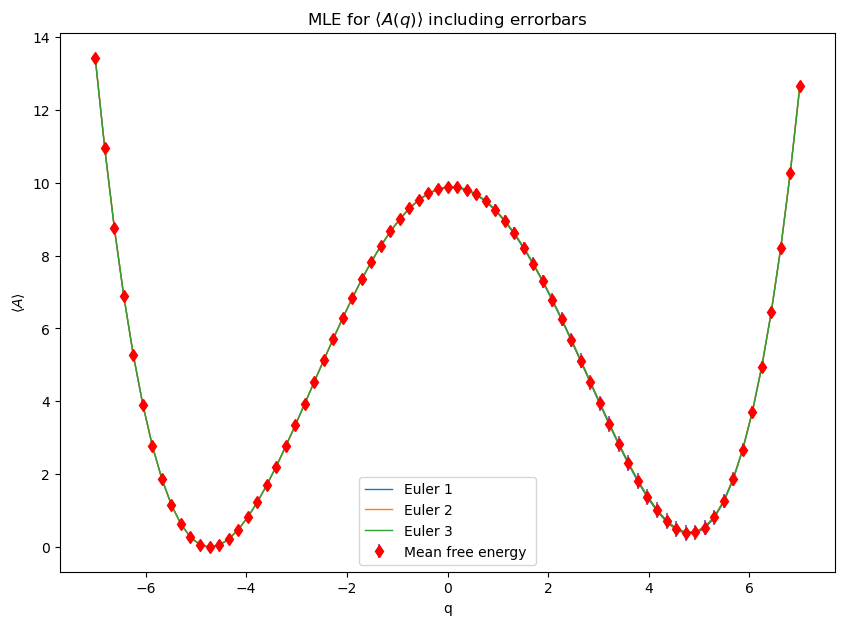

In [5]:
# fig,xa = plt.subplots()
Euler_mean_fes=np.empty_like(Euler_fes[0])
for i in range(len(xfa)): #sum over xfa points
    sum=0
    for j in range(M):
        sum += Euler_fes[j][i]
    Euler_mean_fes[i]= sum/M

# xa.scatter(xfa,Euler_mean_fes)

Euler_var_fes=np.empty_like(xfa)
err =np.empty_like(Euler_var_fes)
for i in range(len(xfa)):
    sum=0
    for j in range(M):
        sum += (Euler_fes[j][i] - Euler_mean_fes[i])**2
    Euler_var_fes[i]= sum/(M-1)

Euler_err = np.sqrt(Euler_var_fes)
fig, ax =plt.subplots(figsize=(10,7))
ax.errorbar(xfa,Euler_mean_fes,yerr=10*Euler_err,fmt='d',color ='red', ecolor='C4',alpha=1, label="Mean free energy ")
ax.set_xlabel('q')
ax.set_ylabel('$\\langle A \\rangle$')
ax.set_title("MLE for $\\langle A (q)\\rangle$ including errorbars")


ax.plot(xfa,Euler_fes[0],label ='Euler 1',linewidth=1)
ax.plot(xfa,Euler_fes[1],label ='Euler 2',linewidth=1)
ax.plot(xfa,Euler_fes[2],label ='Euler 3',linewidth=1)
print(10*Euler_err)
ax.legend()


### Elerian training

random [2.7226118  2.64524102 2.91725852 2.37299932 2.95618183 2.52278197
 1.68613525 3.88462238]


/home/dbersano/folie/folie/estimation/transitionDensity.py:11: RuntimeWarning: invalid value encountered in log
  return -0.5 * ((xt.ravel() - E) ** 2 / V) - 0.5 * np.log(np.sqrt(2 * np.pi) * V)
/home/dbersano/folie/folie/estimation/transitionDensity.py:11: RuntimeWarning: invalid value encountered in log
  return -0.5 * ((xt.ravel() - E) ** 2 / V) - 0.5 * np.log(np.sqrt(2 * np.pi) * V)
/home/dbersano/folie/folie/estimation/transitionDensity.py:11: RuntimeWarning: invalid value encountered in log
  return -0.5 * ((xt.ravel() - E) ** 2 / V) - 0.5 * np.log(np.sqrt(2 * np.pi) * V)
/home/dbersano/folie/folie/estimation/transitionDensity.py:11: RuntimeWarning: invalid value encountered in log
  return -0.5 * ((xt.ravel() - E) ** 2 / V) - 0.5 * np.log(np.sqrt(2 * np.pi) * V)


Elerian 1 [2.7226118  2.64524102 2.91725852 2.37299932 2.95618183 2.52278197
 1.68613525 3.88462238]
random [3.88131804 4.70957306 3.05003364 2.59532259 2.45464005 1.45352268
 3.98236743 1.89893237]
Elerian 2 [3.88131804 4.70957306 3.05003364 2.59532259 2.45464005 1.45352268
 3.98236743 1.89893237]
random [1.81495347 2.7943501  4.48614836 3.23671627 1.97621486 2.2870068
 3.62524497 2.83948664]
Elerian 3 [1.81495347 2.7943501  4.48614836 3.23671627 1.97621486 2.2870068
 3.62524497 2.83948664]
Euler KM [  4.26453311 -11.42115499  11.17325308  -3.97170219   0.50618638
   0.48489797   0.50877457   0.49627617]


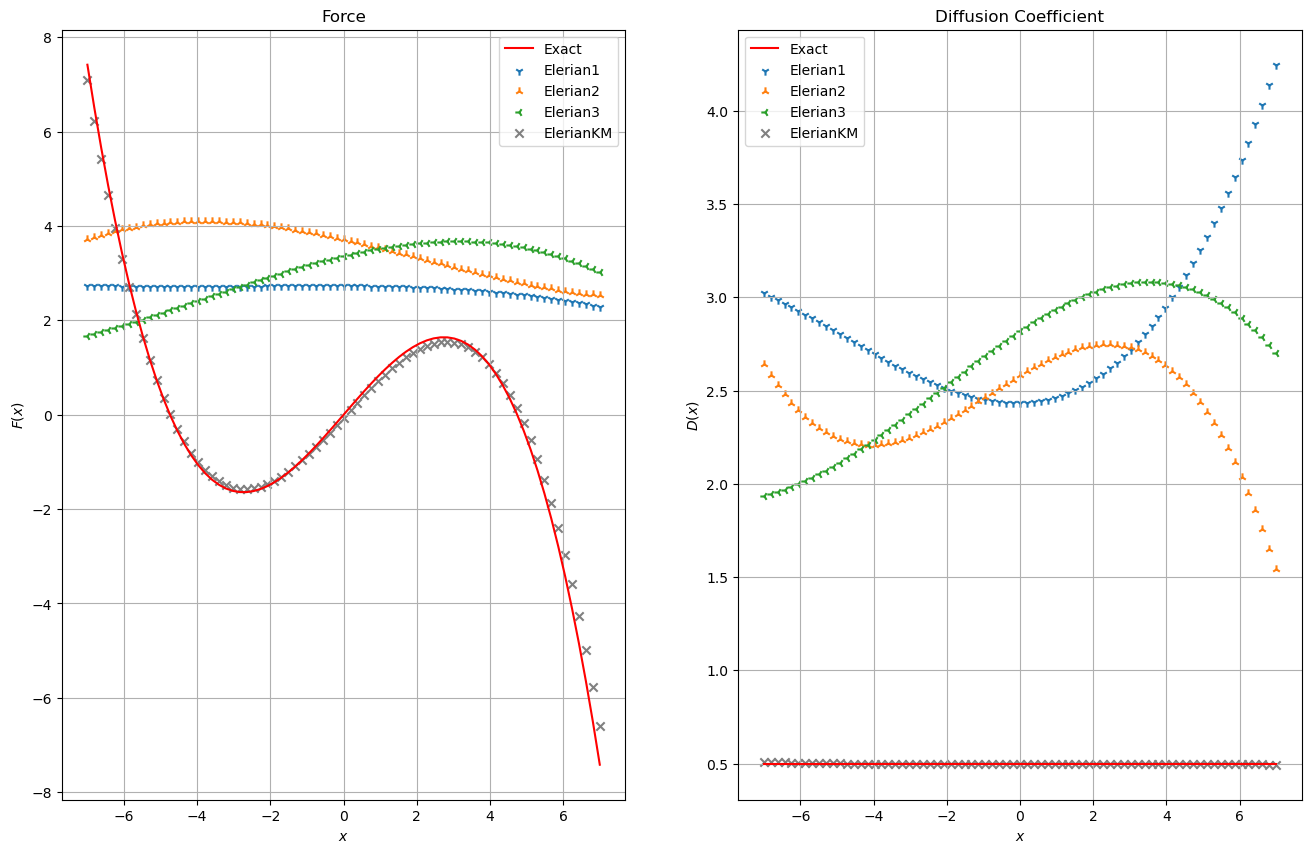

In [6]:
fig, axs = plt.subplots(1, 2,figsize=(16,10))
np.random.seed(3)
axs[0].set_title("Force")
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$F(x)$")
axs[0].grid()

axs[1].set_title("Diffusion Coefficient")
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$D(x)$")
axs[1].grid()

xfa = np.linspace(-7.0, 7.0, 75)
axs[0].plot(xfa, model_simu.force(xfa.reshape(-1, 1)),color='r', label="Exact")
axs[1].plot(xfa, model_simu.diffusion(xfa.reshape(-1, 1)), color='r',label="Exact")

nknots=4
domain = fl.MeshedDomain.create_from_range(np.linspace(data.stats.min, data.stats.max, nknots).ravel())
trainmodel = fl.models.Overdamped(force=fl.functions.BSplinesFunction(domain), has_bias=None)

Elerian_res=[]
Elerian_fes=[]
markers=['1','2','3']
for index in range(M):
    coefficients0= np.random.normal(loc=mu, scale=sigma, size=2*nknots)
    print('random',coefficients0)
    estimator = fl.LikelihoodEstimator(fl.ElerianDensity(trainmodel) ,n_jobs=4)
    Elerian_res.append(estimator.fit_fetch(data,coefficients0=coefficients0))
    print('Elerian',index +1,Elerian_res[index].coefficients)
    axs[0].scatter(xfa, Elerian_res[index].force(xfa.reshape(-1, 1)), marker=markers[index], label='Elerian'+str(index+1))
    axs[1].scatter(xfa, Elerian_res[index].diffusion(xfa.reshape(-1, 1)), marker=markers[index], label='Elerian'+str(index+1))
    Elerian_fes.append(fl.analysis.free_energy_profile_1d(Elerian_res[index],xfa))
    axf.plot(xfa,Elerian_fes[index])

Elerian_res0=fl.LikelihoodEstimator(fl.EulerDensity(trainmodel) ,n_jobs=4).fit_fetch(data)
print('Euler KM',Elerian_res0.coefficients)
axs[0].scatter(xfa, Elerian_res0.force(xfa.reshape(-1, 1)),color = 'grey', marker='x', label='ElerianKM')
axs[1].scatter(xfa, Elerian_res0.diffusion(xfa.reshape(-1, 1)), color = 'grey',marker='x', label='ElerianKM')

axs[0].legend()
axs[1].legend()


#### Elerian errorbars

[41.43625311 40.76710242 40.0633626  39.32801474 38.56429788 37.77568501
 36.96585318 36.13864834 35.29804557 34.44810556 33.59292845 32.73660607
 31.88317375 31.03656281 30.20055482 29.37873851 28.57447028 27.79083885
 27.0306347  26.29632462 25.59003163 24.91352052 24.26818892 23.65506385
 23.07480385 22.5277061  22.01371856 21.53245652 21.08322315 20.66503336
 20.27664037 19.91656422 19.58312128 19.27445423 18.98856144 18.7233253
 18.47653883 18.24593009 18.02918416 17.82396234 17.62791883 17.43871453
 17.25402844 17.07156666 16.88906923 16.70431495 16.51512455 16.31936206
 16.11493481 15.89979173 15.67192031 15.42934182 15.17010485 14.89227683
 14.5939333  14.27314458 13.92795928 13.55638417 13.15635964 12.72572982
 12.26220617 11.76332305 11.22638328 10.648391   10.02596836  9.35525118
  8.63175691  7.85021561  7.00435057  6.08658933  5.08767624  3.99614311
  2.79756961  1.47352388  0.        ]


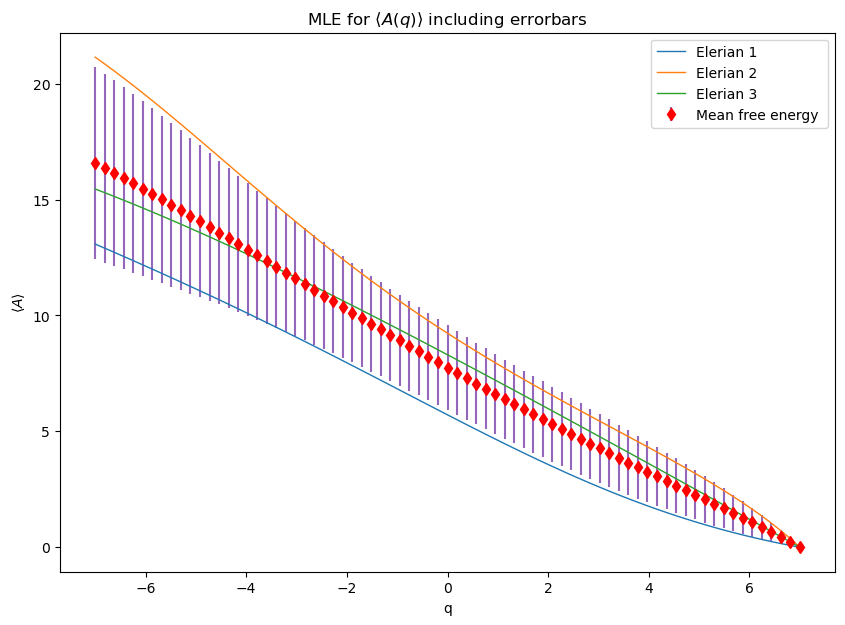

In [7]:
# fig,xa = plt.subplots()
Elerian_mean_fes=np.empty_like(Elerian_fes[0])
for i in range(len(xfa)): #sum over xfa points
    sum=0
    for j in range(M):
        sum += Elerian_fes[j][i]
    Elerian_mean_fes[i]= sum/M

# xa.scatter(xfa,Elerian_mean_fes)

Elerian_var_fes=np.empty_like(xfa)
err =np.empty_like(Elerian_var_fes)
for i in range(len(xfa)):
    sum=0
    for j in range(M):
        sum += (Elerian_fes[j][i] - Elerian_mean_fes[i])**2
    Elerian_var_fes[i]= sum/(M-1)

Elerian_err = np.sqrt(Elerian_var_fes)
fig, ax =plt.subplots(figsize=(10,7))
ax.errorbar(xfa,Elerian_mean_fes,yerr=1*Elerian_err,fmt='d',color ='red', ecolor='C4',alpha=1, label="Mean free energy ")
ax.set_xlabel('q')
ax.set_ylabel('$\\langle A \\rangle$')
ax.set_title("MLE for $\\langle A (q)\\rangle$ including errorbars")


ax.plot(xfa,Elerian_fes[0],label ='Elerian 1',linewidth=1)
ax.plot(xfa,Elerian_fes[1],label ='Elerian 2',linewidth=1)
ax.plot(xfa,Elerian_fes[2],label ='Elerian 3',linewidth=1)
print(10*Elerian_err)
ax.legend()

### Kessler training

random [2.7226118  2.64524102 2.91725852 2.37299932 2.95618183 2.52278197
 1.68613525 3.88462238]
Kessler 1 [  4.30578011 -11.50448671  11.18502409  -3.97316644   0.50753882
   0.48521726   0.50580837   0.49880759]
random [3.88131804 4.70957306 3.05003364 2.59532259 2.45464005 1.45352268
 3.98236743 1.89893237]
Kessler 2 [  4.27299747 -11.35969019  11.16504412  -4.04049955   0.50796249
   0.48409173   0.5074968    0.49820493]
random [1.81495347 2.7943501  4.48614836 3.23671627 1.97621486 2.2870068
 3.62524497 2.83948664]
Kessler 3 [  4.30605657 -11.49409097  11.18569104  -3.97932776   0.5079633
   0.48380882   0.50744624   0.49811625]
Kessler KM [  4.26452822 -11.42115114  11.17324441  -3.97170566   0.50811996
   0.48360291   0.50765147   0.49805638]


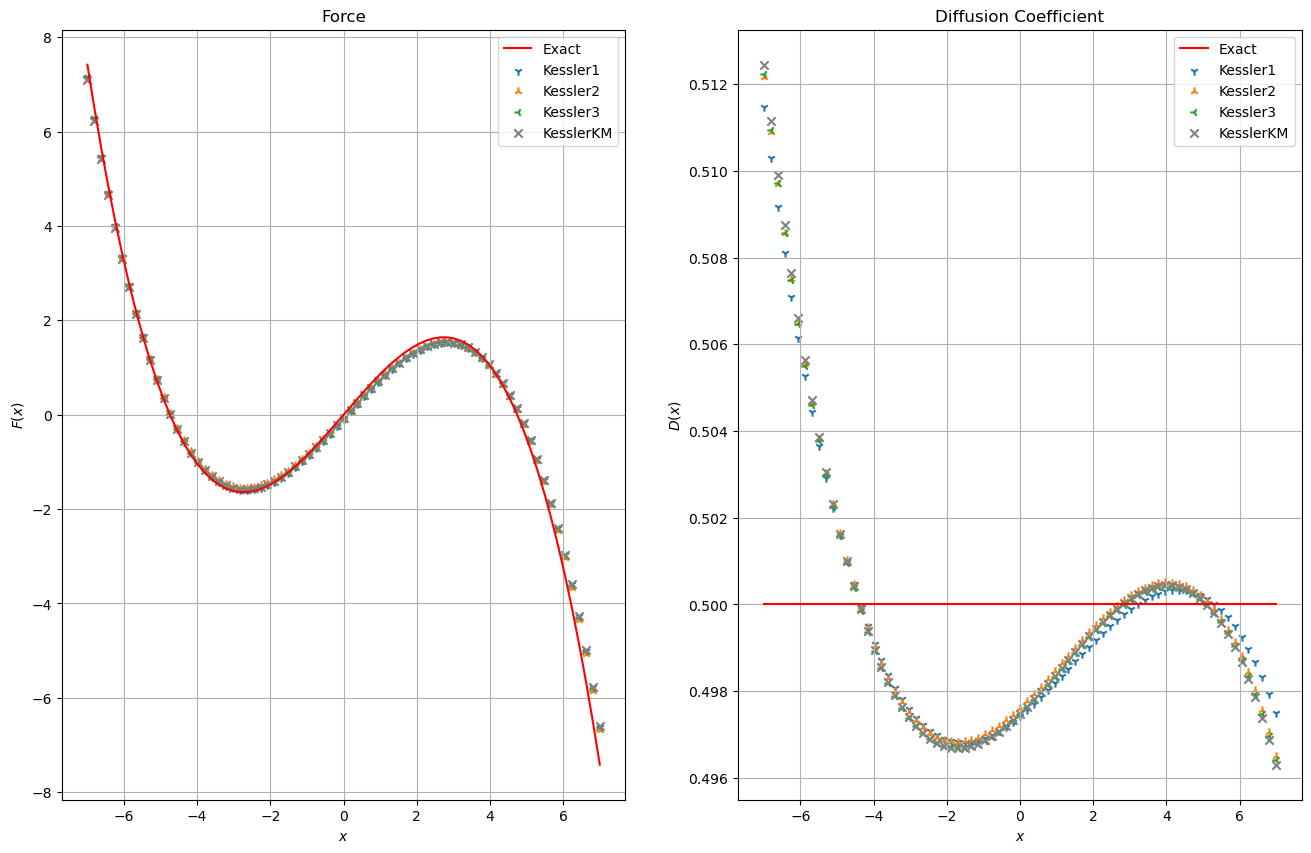

In [8]:
fig, axs = plt.subplots(1, 2,figsize=(16,10))
np.random.seed(3)
axs[0].set_title("Force")
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$F(x)$")
axs[0].grid()

axs[1].set_title("Diffusion Coefficient")
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$D(x)$")
axs[1].grid()

xfa = np.linspace(-7.0, 7.0, 75)
axs[0].plot(xfa, model_simu.force(xfa.reshape(-1, 1)),color='r', label="Exact")
axs[1].plot(xfa, model_simu.diffusion(xfa.reshape(-1, 1)), color='r',label="Exact")

nknots=4
domain = fl.MeshedDomain.create_from_range(np.linspace(data.stats.min, data.stats.max, nknots).ravel())
trainmodel = fl.models.Overdamped(force=fl.functions.BSplinesFunction(domain), has_bias=None)

Kessler_res=[]
Kessler_fes=[]
markers=['1','2','3']
for index in range(M):
    coefficients0= np.random.normal(loc=mu, scale=sigma, size=2*nknots)
    print('random',coefficients0)
    estimator = fl.LikelihoodEstimator(fl.KesslerDensity(trainmodel) ,n_jobs=4)
    Kessler_res.append(estimator.fit_fetch(data,coefficients0=coefficients0))
    print('Kessler',index +1,Kessler_res[index].coefficients)
    axs[0].scatter(xfa, Kessler_res[index].force(xfa.reshape(-1, 1)), marker=markers[index], label='Kessler'+str(index+1))
    axs[1].scatter(xfa, Kessler_res[index].diffusion(xfa.reshape(-1, 1)), marker=markers[index], label='Kessler'+str(index+1))
    Kessler_fes.append(fl.analysis.free_energy_profile_1d(Kessler_res[index],xfa))
    axf.plot(xfa,Kessler_fes[index])

Kessler_res0=fl.LikelihoodEstimator(fl.KesslerDensity(trainmodel) ,n_jobs=4).fit_fetch(data)
print('Kessler KM',Kessler_res0.coefficients)
axs[0].scatter(xfa, Kessler_res0.force(xfa.reshape(-1, 1)),color = 'grey', marker='x', label='KesslerKM')
axs[1].scatter(xfa, Kessler_res0.diffusion(xfa.reshape(-1, 1)), color = 'grey',marker='x', label='KesslerKM')

axs[0].legend()
axs[1].legend()

#### Kessler errorbars

[0.49169303 0.35739862 0.24436488 0.1514678  0.07830453 0.0300799
 0.03620655 0.05836242 0.06994906 0.06932828 0.0569538  0.03357587
 0.         0.04296768 0.09453606 0.15393381 0.22041054 0.29323654
 0.37170221 0.45511721 0.54280982 0.63412624 0.72843011 0.82510214
 0.92353981 1.02315726 1.12338527 1.22367133 1.32347979 1.42229216
 1.51960743 1.61494243 1.70783237 1.79783126 1.88451251 1.96746945
 2.04631593 2.12068689 2.19023893 2.25465085 2.31362413 2.36688345
 2.41417702 2.45527694 2.48997942 2.51810495 2.53949829 2.55402839
 2.56158819 2.56209422 2.5554861  2.54172585 2.52079703 2.4927037
 2.4574692  2.41513465 2.36575733 2.30940877 2.24617252 2.17614176
 2.09941646 2.01610029 1.92629709 1.83010689 1.72762149 1.6189195
 1.50406101 1.38308185 1.2559882  1.12275257 0.98331445 0.83759439
 0.68554802 0.52735718 0.36422812]


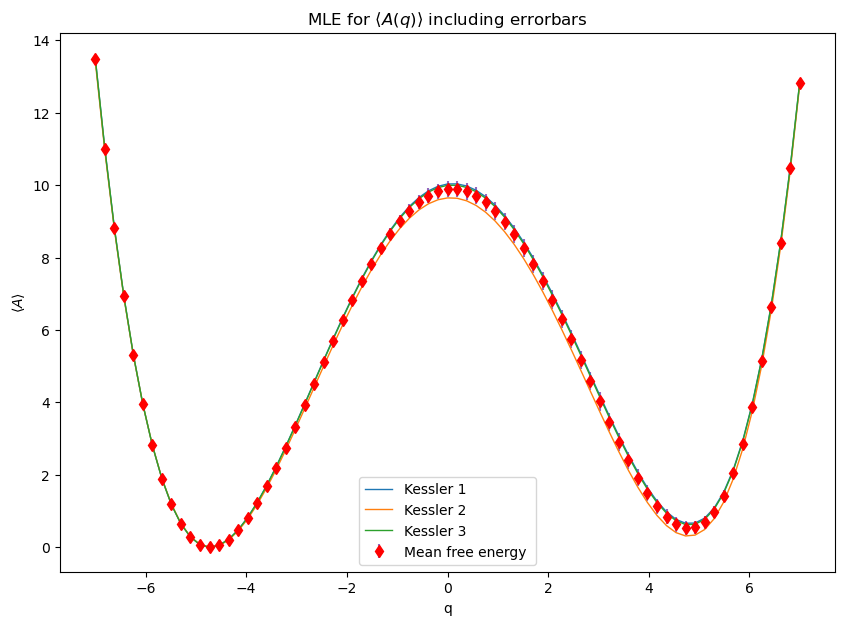

In [9]:
# fig,xa = plt.subplots()
Kessler_mean_fes=np.empty_like(Kessler_fes[0])
for i in range(len(xfa)): #sum over xfa points
    sum=0
    for j in range(M):
        sum += Kessler_fes[j][i]
    Kessler_mean_fes[i]= sum/M

# xa.scatter(xfa,Kessler_mean_fes)

Kessler_var_fes=np.empty_like(xfa)
err =np.empty_like(Kessler_var_fes)
for i in range(len(xfa)):
    sum=0
    for j in range(M):
        sum += (Kessler_fes[j][i] - Kessler_mean_fes[i])**2
    Kessler_var_fes[i]= sum/(M-1)

Kessler_err = np.sqrt(Kessler_var_fes)
fig, ax =plt.subplots(figsize=(10,7))
ax.errorbar(xfa,Kessler_mean_fes,yerr=1*Kessler_err,fmt='d',color ='red', ecolor='C4',alpha=1, label="Mean free energy ")
ax.set_xlabel('q')
ax.set_ylabel('$\\langle A \\rangle$')
ax.set_title("MLE for $\\langle A (q)\\rangle$ including errorbars")


ax.plot(xfa,Kessler_fes[0],label ='Kessler 1',linewidth=1)
ax.plot(xfa,Kessler_fes[1],label ='Kessler 2',linewidth=1)
ax.plot(xfa,Kessler_fes[2],label ='Kessler 3',linewidth=1)
print(10*Kessler_err)
ax.legend()

### Drozdov Training

random [2.7226118  2.64524102 2.91725852 2.37299932 2.95618183 2.52278197
 1.68613525 3.88462238]
Drozdov 1 [  4.2688907  -11.4309607   11.18343001  -3.97324437   0.50811151
   0.48367613   0.5075091    0.49812823]
random [3.88131804 4.70957306 3.05003364 2.59532259 2.45464005 1.45352268
 3.98236743 1.89893237]
Drozdov 2 [  4.27344163 -11.4396834   11.19244911  -3.97938618   0.50817676
   0.48336041   0.50785056   0.49802412]
random [1.81495347 2.7943501  4.48614836 3.23671627 1.97621486 2.2870068
 3.62524497 2.83948664]
Drozdov 3 [  4.27766868 -11.45352144  11.20696892  -3.99100724  -0.50801703
  -0.48379918  -0.50738041  -0.49823869]
Drozdov KM [  4.26453311 -11.42115499  11.17325308  -3.97170219   0.50618638
   0.48489797   0.50877457   0.49627617]


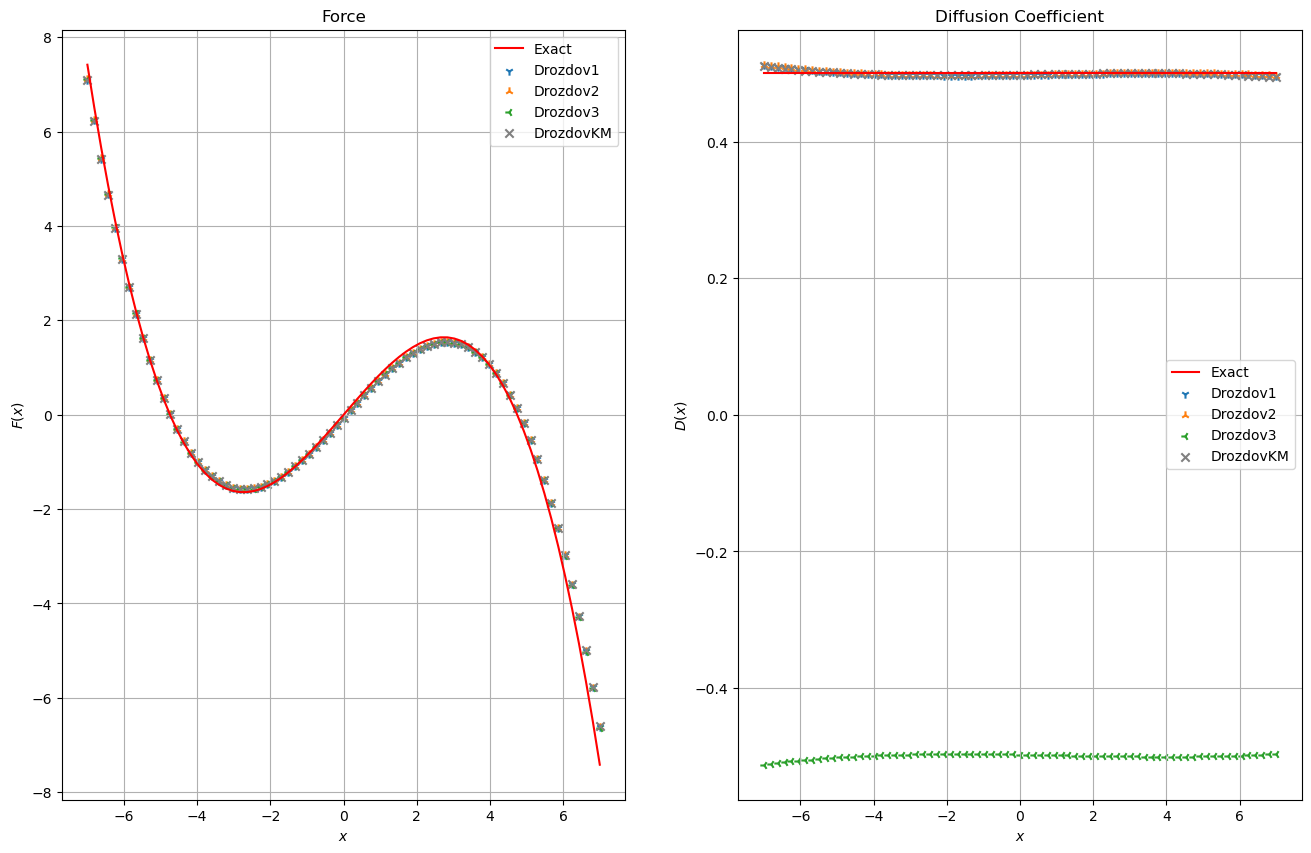

In [10]:
#  DROZDOV
fig, axs = plt.subplots(1, 2,figsize=(16,10))
np.random.seed(3)
axs[0].set_title("Force")
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$F(x)$")
axs[0].grid()

axs[1].set_title("Diffusion Coefficient")
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$D(x)$")
axs[1].grid()

xfa = np.linspace(-7.0, 7.0, 75)
axs[0].plot(xfa, model_simu.force(xfa.reshape(-1, 1)),color='r', label="Exact")
axs[1].plot(xfa, model_simu.diffusion(xfa.reshape(-1, 1)), color='r',label="Exact")

nknots=4
domain = fl.MeshedDomain.create_from_range(np.linspace(data.stats.min, data.stats.max, nknots).ravel())
trainmodel = fl.models.Overdamped(force=fl.functions.BSplinesFunction(domain), has_bias=None)

Drozdov_res=[]
Drozdov_fes=[]
markers=['1','2','3']
for index in range(M):
    coefficients0= np.random.normal(loc=mu, scale=sigma, size=2*nknots)
    print('random',coefficients0)
    estimator = fl.LikelihoodEstimator(fl.DrozdovDensity(trainmodel) ,n_jobs=4)
    Drozdov_res.append(estimator.fit_fetch(data,coefficients0=coefficients0))
    print('Drozdov',index +1,Drozdov_res[index].coefficients)
    axs[0].scatter(xfa, Drozdov_res[index].force(xfa.reshape(-1, 1)), marker=markers[index], label='Drozdov'+str(index+1))
    axs[1].scatter(xfa, Drozdov_res[index].diffusion(xfa.reshape(-1, 1)), marker=markers[index], label='Drozdov'+str(index+1))
    Drozdov_fes.append(fl.analysis.free_energy_profile_1d(Drozdov_res[index],xfa))
    axf.plot(xfa,Drozdov_fes[index])

Drozdov_res0=fl.LikelihoodEstimator(fl.EulerDensity(trainmodel) ,n_jobs=4).fit_fetch(data)
print('Drozdov KM',Drozdov_res0.coefficients)
axs[0].scatter(xfa, Drozdov_res0.force(xfa.reshape(-1, 1)),color = 'grey', marker='x', label='DrozdovKM')
axs[1].scatter(xfa, Drozdov_res0.diffusion(xfa.reshape(-1, 1)), color = 'grey',marker='x', label='DrozdovKM')

axs[0].legend()
axs[1].legend()

#### Drozdov errorbars

[77.27888335 48.76411805 23.77368868  2.09502597 16.48240988 32.16263843
 45.14749035 55.63392204 63.8143614  69.87649699 74.00308571 76.37177153
 77.15491458 76.51943043 74.62663961 71.63212722 67.68561254 62.9308286
 57.50541146 51.54079907 45.16213938 38.48820764 31.63133244 24.69733023
 17.78544816 10.98831505  4.39190394  1.92458744  7.88846217 13.43402981
 18.50222962 23.04079531 27.00424094 30.35386105 33.05772774 35.09068408
 36.43433438 37.07703182 37.01386364 36.24663463 34.78384915 32.64069218
 29.83900998 26.40729054 22.38064458 17.80078733 12.71602197  7.18122732
  1.2579383   4.98627923 11.47639698 18.13157964 24.86422631 31.58020826
 38.17885249 44.55292767 50.58862552 56.16553641 61.15661873 65.42816149
 68.83973978 71.24416248 72.48741191 72.40857482 70.8397642  67.60603155
 62.5252689  55.40810042 46.05776335 34.26998075 19.83284854  2.52816268
 17.87754828 41.61374438 68.92734851]


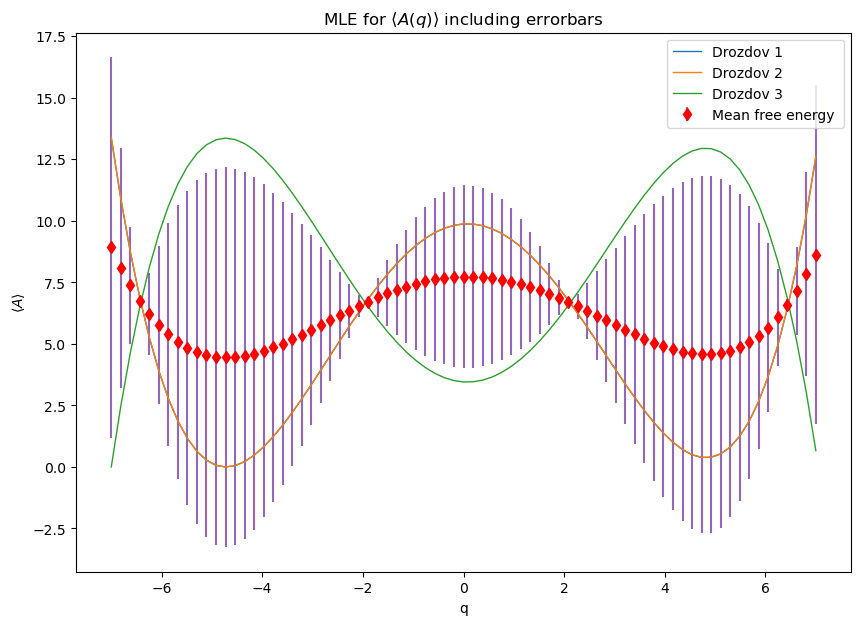

In [11]:
# fig,xa = plt.subplots()
Drozdov_mean_fes=np.empty_like(Drozdov_fes[0])
for i in range(len(xfa)): #sum over xfa points
    sum=0
    for j in range(M):
        sum += Drozdov_fes[j][i]
    Drozdov_mean_fes[i]= sum/M

# xa.scatter(xfa,Drozdov_mean_fes)

Drozdov_var_fes=np.empty_like(xfa)
err =np.empty_like(Drozdov_var_fes)
for i in range(len(xfa)):
    sum=0
    for j in range(M):
        sum += (Drozdov_fes[j][i] - Drozdov_mean_fes[i])**2
    Drozdov_var_fes[i]= sum/(M-1)

Drozdov_err = np.sqrt(Drozdov_var_fes)
fig, ax =plt.subplots(figsize=(10,7))
ax.errorbar(xfa,Drozdov_mean_fes,yerr=1*Drozdov_err,fmt='d',color ='red', ecolor='C4',alpha=1, label="Mean free energy ")
ax.set_xlabel('q')
ax.set_ylabel('$\\langle A \\rangle$')
ax.set_title("MLE for $\\langle A (q)\\rangle$ including errorbars")


ax.plot(xfa,Drozdov_fes[0],label ='Drozdov 1',linewidth=1)
ax.plot(xfa,Drozdov_fes[1],label ='Drozdov 2',linewidth=1)
ax.plot(xfa,Drozdov_fes[2],label ='Drozdov 3',linewidth=1)
print(10*Drozdov_err)
ax.legend()